In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import datetime
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

from hpc_runtime_prediction.operation_support import train_test_split

In [2]:
# Import pkl file
filepath = os.path.join('../data/', 'eagle_data_anonymized_20230222.pkl')
eagle_df = pd.read_pickle(filepath)

In [5]:
def timedelta64_to_xsd_duration(td):
    td_dt = td
    
    days, remainder = divmod(td_dt, 86400)
    hours, remainder = divmod(remainder, 3600)
    minutes, seconds = divmod(remainder, 60)
    return 'P{:.0f}DT{:.0f}H{:.0f}M{:.0f}S'.format(days, hours, minutes, seconds)

In [6]:
eagle_df['wallclock_req_XSD_duration'] = eagle_df['wallclock_req'].apply(timedelta64_to_xsd_duration)

In [51]:
date_list = pd.date_range(start='01-01-2019', end='12-31-2022', freq=pd.Timedelta('6 days'))
date_list

DatetimeIndex(['2019-01-01', '2019-01-07', '2019-01-13', '2019-01-19',
               '2019-01-25', '2019-01-31', '2019-02-06', '2019-02-12',
               '2019-02-18', '2019-02-24',
               ...
               '2022-11-05', '2022-11-11', '2022-11-17', '2022-11-23',
               '2022-11-29', '2022-12-05', '2022-12-11', '2022-12-17',
               '2022-12-23', '2022-12-29'],
              dtype='datetime64[ns]', length=244, freq='6D')

In [26]:
r2_dict = dict()
rmse_dict = dict()

train_days = 110

for m in [1] + list(range(50,1000,50)):
    r2_dict[m] = list()
    rmse_dict[m] = list()

for split_time in date_list:
    train_df = eagle_df[eagle_df.end_time.between(split_time - datetime.timedelta(train_days), split_time)]
    features = ['wallclock_req_XSD_duration','nodes_req','processors_req','gpus_req','mem_req','user','account','partition','qos','work_dir','name']
    X_train = ''

    for feature in features:
        X_train += train_df[feature].astype('str')
    X_train = X_train.values
    y_train = train_df.run_time.values
    for m in [1] + list(range(50,1000,50)):
        vect = TfidfVectorizer(max_features=m)
        X_train_vec = vect.fit_transform(X_train)

        regressor = LinearRegression(n_jobs=-1)
        regressor.fit(X_train_vec, y_train)

        for test_days in [1]:
            test_df = eagle_df[eagle_df.submit_time.between(split_time + datetime.timedelta(test_days - 1), split_time + datetime.timedelta(test_days))]
            if len(train_df) < 2 or len(test_df) < 2:
                continue

            X_test = ''
            for feature in features:
                X_test += test_df[feature].astype('str')
            X_test = X_test.values
            X_test_vec = vect.transform(X_test)
            y_test = test_df.run_time.values

            y_pred = regressor.predict(X_test_vec)

            r2 = r2_score(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            r2_dict[m].append(r2)
            rmse_dict[m].append(rmse)
            if m == 500:
                print(f'm: {m}, Split time: {split_time}, r2: {r2}, rmse: {rmse}')

m: 500, Split time: 2019-01-01 00:00:00, r2: 0.301901192161276, rmse: 32182.205248661165
m: 500, Split time: 2019-01-07 00:00:00, r2: 0.10594842556625161, rmse: 41474.46860722997
m: 500, Split time: 2019-01-13 00:00:00, r2: 0.23297377887741832, rmse: 32211.40999216593
m: 500, Split time: 2019-01-19 00:00:00, r2: -0.37246037048913316, rmse: 50964.95617637889
m: 500, Split time: 2019-01-25 00:00:00, r2: 0.11656396122068369, rmse: 26532.45478959566
m: 500, Split time: 2019-01-31 00:00:00, r2: 0.5434059654919496, rmse: 20604.918527291684
m: 500, Split time: 2019-02-06 00:00:00, r2: -0.26495869483893886, rmse: 47867.31545437276
m: 500, Split time: 2019-02-12 00:00:00, r2: 0.1166534409104375, rmse: 46672.89096120352
m: 500, Split time: 2019-02-18 00:00:00, r2: -0.5375766677409581, rmse: 31327.99866460546
m: 500, Split time: 2019-02-24 00:00:00, r2: -0.0313851506021261, rmse: 25952.825634596276
m: 500, Split time: 2019-03-02 00:00:00, r2: -0.08168176927983972, rmse: 91187.97620725946
m: 500, 

In [27]:
max_features_df = pd.DataFrame({'m': list(r2_dict.keys()), 'r2': list(r2_dict.values()), 'rmse': list(rmse_dict.values())})

In [ ]:
training_nn_df['r2'] = training_nn_df.r2.apply(lambda x: x[0] if len(x) > 0 else np.nan)
training_nn_df['rmse'] = training_nn_df.rmse.apply(lambda x: x[0] if len(x) > 0 else np.nan)

In [28]:
max_features_df.to_pickle('tfidf_max_features_optimization.pkl')

In [30]:
max_features_df

,m,r2,rmse
0,1,"[-0.03717323127694416, -0.159193617831497, -0....","[39226.81089780131, 47225.60549400471, 37389.4..."
1,50,"[-0.0006801398460971608, -0.10187881334755189,...","[38530.53084374621, 46043.30188732603, 32543.2..."
2,100,"[0.01482225255305003, -0.06991115863232178, 0....","[38230.91118490743, 45370.4830018569, 32327.20..."
3,150,"[0.29551450440002625, 0.2296355680706188, 0.22...","[32329.082547574748, 38498.8410277685, 32305.7..."
4,200,"[0.29051827262313756, 0.06514858705212723, 0.2...","[32443.51940899982, 42410.25058623096, 32040.0..."
5,250,"[0.29245419666525707, 0.07335811903421885, 0.2...","[32399.225743156654, 42223.624106885545, 30996..."
6,300,"[0.2964023224552861, 0.07309265895755557, 0.25...","[32308.704986922374, 42229.67168798697, 31782...."
7,350,"[0.3018520583080261, 0.0023548605656564803, 0....","[32183.337758780355, 43811.446234676085, 31935..."
8,400,"[0.30316526653623477, 0.08636996546204201, 0.2...","[32153.05526820931, 41926.125326214424, 32015...."
9,450,"[0.3032505138671181, 0.052441253970038404, 0.2...","[32151.088484807304, 42697.516637694964, 32113..."


In [41]:
rmse_m = list()
rmse_avg_value = list()

for key, value in rmse_dict.items():
    rmse_m.append(key)
    rmse_avg_value.append(sum(value)/(len(value) * 3600))

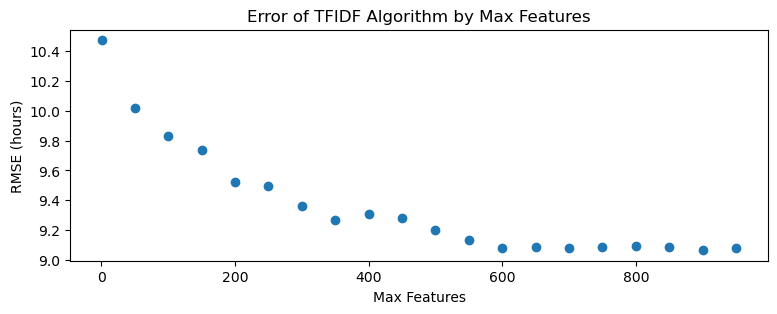

In [50]:
fig = plt.figure(figsize=(9,3))
plt.scatter(rmse_m, rmse_avg_value)
plt.title('Error of TFIDF Algorithm by Max Features')
plt.ylabel('RMSE (hours)')
plt.xlabel('Max Features')
plt.savefig('TFIDF_max_features_optimization.jpg', dpi=300)

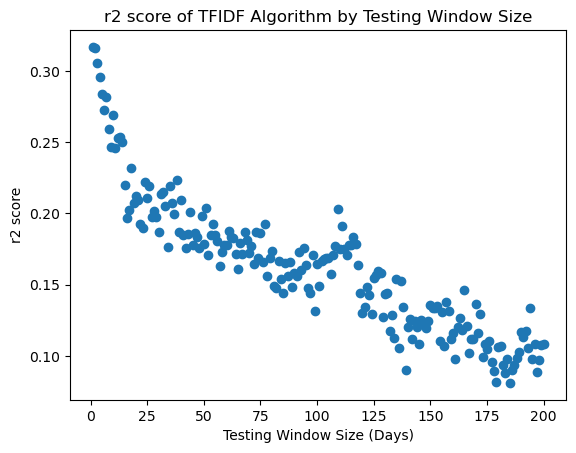

In [50]:
r2_train_window = list()
r2_avg_value = list()

r2_dict_cleaned = r2_dict
for day, data in r2_dict_cleaned.items():
    for value in data:
        if value < 0:
            r2_dict_cleaned[day].remove(value)

for key, value in r2_dict_cleaned.items():
    r2_train_window.append(key)
    r2_avg_value.append(sum(value)/len(value))
    
plt.scatter(r2_train_window, r2_avg_value)
plt.title('r2 score of TFIDF Algorithm by Testing Window Size')
plt.ylabel('r2 score')
plt.xlabel('Testing Window Size (Days)')
plt.savefig('TFIDF_r2_test.jpg', dpi=300)

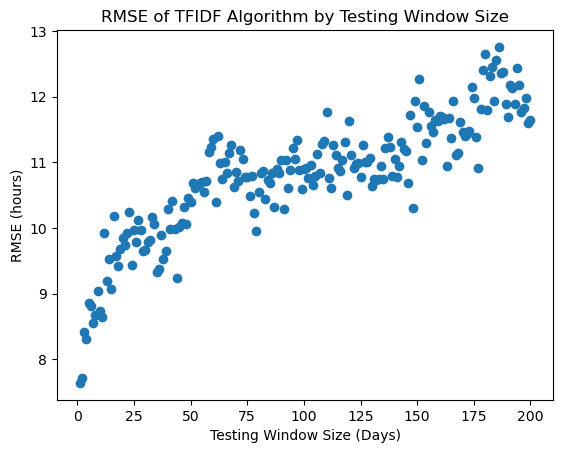

In [38]:
rmse_train_window = list()
rmse_avg_value = list()
for key, value in rmse_dict.items():
    rmse_train_window.append(key)
    rmse_avg_value.append(sum(value)/(len(value) * 3600))
    
plt.scatter(rmse_train_window, rmse_avg_value)
plt.title('RMSE of TFIDF Algorithm by Testing Window Size')
plt.ylabel('RMSE (hours)')
plt.xlabel('Testing Window Size (Days)')
plt.savefig('TFIDF_rmse_test.jpg', dpi=300)